<a href="https://colab.research.google.com/github/Strojove-uceni/23206-final-acoustic-emission-classification/blob/main/AE_classificatio_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimizing the Drill - Acoustic Emission Classification
* Barbora Bumbálková, Jan Zavadil
## Abstract
The goal of this project is to find an automated, reliable and cheap method to monitor the level of sharpness of a drill in a manufacturing line in order to facilitate optimal replacement of worn bits. The chosen approach relies on the phenomenon of acoustic emission - the process of solid materials emmiting ultrasound waves during irreversible structural changes. Acoustic emission (AE) signals are measured with sensors on the surface of an object of interest during drilling, the level of drill sharpness is also recorded. In our setup, we measured AE signals with five different levels of drill sharpness, which led us to formulate a simple classification machine learning task with five classes. We encorporated 1D Convolutional layers to perform the featurization of measured signals followed by a fully connected network performing the classification. Multiple network architectures were tested, the best classifying with accuracy of over 80%.

In [1]:
# @title Imports and Helper Functions
%%capture
!pip install lightning
!pip3 install wandb
!pip install torchview

import torchview
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import wandb
import requests
import IPython

from IPython.display import Image
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.loggers import WandbLogger
from sklearn.model_selection import train_test_split
from torchmetrics.classification import Accuracy, MulticlassConfusionMatrix
from pytorch_lightning.utilities.model_summary import ModelSummary
from torch import argmax
from sklearn.preprocessing import StandardScaler

#Connecting git repository
!git clone https://github.com/Strojove-uceni/23206-final-acoustic-emission-classification.git

#Creates torch.Dataset
class SignalDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        signal = self.data[index]
        label = self.labels[index]
        return signal, label

In [2]:
# @title Loading test data from the repository
path = '/content/23206-final-acoustic-emission-classification/Test_dataset_seed=43.pkl'
with open(path, 'rb') as pickle_file:
            loaded_data = pickle.load(pickle_file)
X_test_np = loaded_data['X_test']
X_test_np = np.moveaxis(X_test_np,1,2)
y_test = loaded_data['y_test']
y_test = nn.functional.one_hot(torch.from_numpy(y_test)).float()

## Methodology
### 1. Experiment
An experiment was carried out in cooperation with the Institute of Thermomechanics of CAS to provide a dataset imitating a production process. The experiment setup is on the following picture.
<div>
<img src=https://drive.google.com/uc?export=view&id=1-fw3ArRU-Iz2MzfyMHi13tauq9PN0Fnh width="500">
</div>


AE signals were detected by four piezoelectric sensors. For each level of sharpness of the drill a few seconds long period of drilling under constant pressure was measured, then the drill was taken out and manually blunted by a grinding stone.

### 2. Data preparation

The sampling frequency was 3,125 MHz, so the resulting signals of continuous AE were unbearably long for any direct analysis. For this reason shorter sections - samples - were randomly cut out from the original signals. The cuts were synchronised along four channels coming from the four sensors used. After a few attempts the length of samples was chosen to be 6000 as it still allowed relatively easy manipulation with the data. In total 2500 samples were extracted for each of five sharpness levels, resulting in our final dataset being of the dimensions (12500, 4, 6000). In the figure below, first data sample of the first category is displayed.

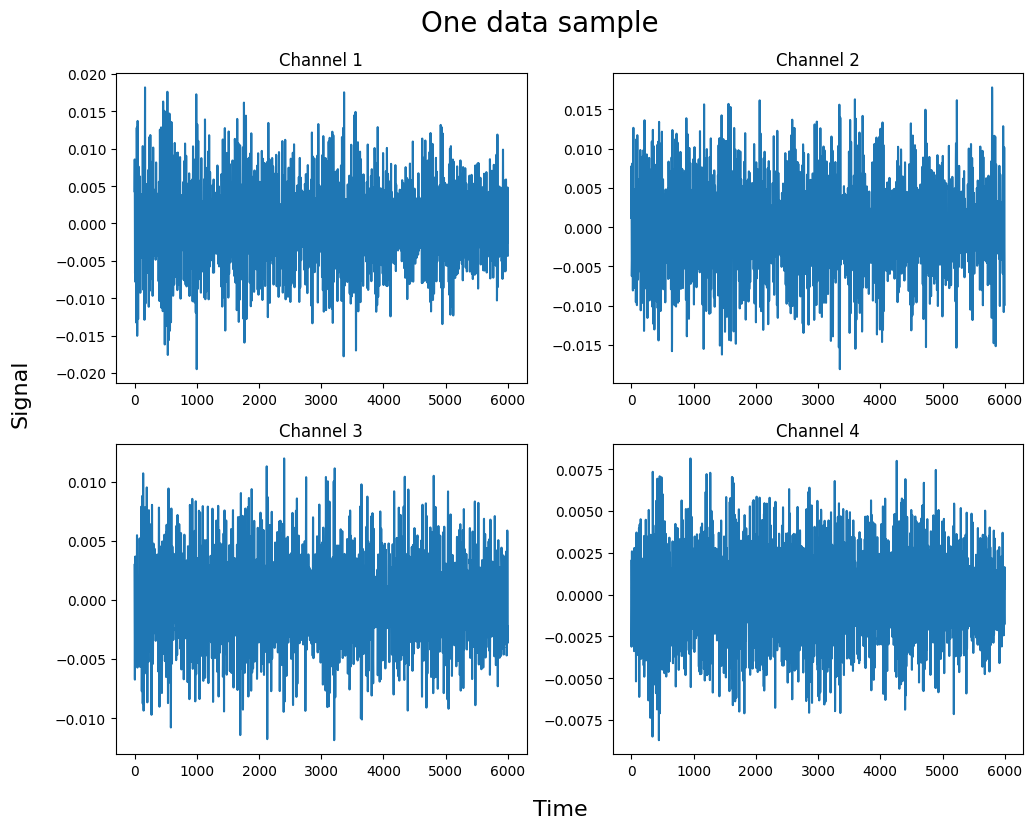

In [3]:
# @title Data Visualisation
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].plot(X_test_np[0, 0, :])
axs[0, 0].set_title('Channel 1')

axs[0, 1].plot(X_test_np[0, 1, :])
axs[0, 1].set_title('Channel 2')

axs[1, 0].plot(X_test_np[0, 2, :])
axs[1, 0].set_title('Channel 3')

axs[1, 1].plot(X_test_np[0, 3, :])
axs[1, 1].set_title('Channel 4')

fig.text(0.52, -0.02, 'Time', ha='center', va='center', size = 16)
fig.text(-0.02, 0.5, 'Signal', ha='center', va='center', rotation='vertical', size = 16)

fig.suptitle('One data sample', fontsize=20)
# Adjust layout to prevent overlap of titles and labels
plt.tight_layout()

# Show the plot
plt.show()

### 3. Classification
To train the implemented networks the data was randomly separated into *Train/Validation/Test* datasets in ratio 7/2/1. In the following demo only the *Test* dataset is loaded and used as it would be very memory and time demanding to train the networks here. Networks were trained on FNSPE computing cluster Helios and the learned weights are imported. Individual architectures implemented will be further described in the Code&Results part, all of them are based on convolutional layers as they suit our, rather data intensive, task the best, inspiration was drawn from image classification applications.





## Code&Results

In [3]:
#Creates test dataloader - not neccesary to declare pl.DataModule for our use here
X_test = torch.from_numpy(X_test_np).float()
test_dataset = SignalDataset(X_test, y_test)
test_DataLoader = DataLoader(test_dataset, batch_size=1)

## 1. ConvNet2 network

---
The first implemented neural network is directly inspired by LeNet, which was used for image classification. In our 1D application it was necessary to use much bigger filters (ie. 1x501 instead of 5x5 in LeNet) as patterns useful for classification in signals can spread over longer distance. The network itself connsists of two convolutional layers in tandem with maximum pooling layers followed by a fully connected part. Visualisation of the network follows its definition.



In [20]:
# @title Definition of pl.LightningModule for ConvNet2
class ConvNet2(pl.LightningModule):
    def __init__(self, input_channels, num_class, drop):
        super(ConvNet2, self).__init__()

        # input_channels - number of channels in input data - 4 in our case
        # num_class - number of classes to which we classify
        # drop - value of dropout probability used in training (0.1 used)

        self.loss = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=num_class)
        self.test_pred = []  # collect predictions
        self.confusion_matrix = MulticlassConfusionMatrix(num_classes=num_class)
        self.drop = drop
        self.check_path = 'Early_Stopping_checkpoint.pth'
        self.min_val_loss = np.inf
        self.best_epoch = 0

        #The actual definition of nn
        self.all_layers = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=501),
            nn.ReLU(),
            nn.Dropout(self.drop),
            nn.MaxPool1d(kernel_size=5),

            nn.Conv1d(64,64, kernel_size=81),
            nn.ReLU(),
            nn.Dropout(self.drop),
            nn.MaxPool1d(kernel_size=4),

            nn.Flatten(),

            nn.Linear(64*255, 200),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(200, 50),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(50, num_class))


    def forward(self, x):
        return self.all_layers(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)

        loss = self.loss(outputs, labels)
        self.log('train_loss', loss, sync_dist=True, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        y_target = argmax(labels, dim=1)
        y_pred = argmax(outputs, dim=1)

        acc = self.accuracy(y_pred, y_target)
        self.log('train_accuracy', acc, sync_dist=True, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)

        loss = self.loss(outputs, labels)
        self.log('val_loss', loss, sync_dist=True, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        y_target = argmax(labels, dim=1)
        y_pred = argmax(outputs, dim=1)
        acc = self.accuracy(y_pred, y_target)
        self.log('val_accuracy', acc, sync_dist=True, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)

        loss = self.loss(outputs, labels)
        self.log('test_loss', loss, sync_dist=True, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        y_target = argmax(labels, dim=1)
        y_pred = argmax(outputs, dim=1)
        acc = self.accuracy(y_pred, y_target)
        self.log('test_accuracy', acc, sync_dist=True, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        # Collect predictions
        self.test_pred.extend(y_pred.cpu().numpy())
        # Update confusion matrix
        self.confusion_matrix.update(y_pred, y_target)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def on_validation_epoch_end(self):
        validation_loss = self.trainer.callback_metrics['val_loss']
        if validation_loss < self.min_val_loss:
            self.min_val_loss = validation_loss
            torch.save(self.state_dict(), self.check_path)
            self.best_epoch = self.current_epoch

    def on_train_end(self):
        print(f'Best epoch was epoch {self.best_epoch}. Loading its state.')
        self.load_state_dict(torch.load(self.check_path))


In [25]:
#Model inititalisation
model = ConvNet2(input_channels = 4, num_class = 5, drop = 0.1)
#Loading weights
model.load_state_dict(torch.load('/content/23206-final-acoustic-emission-classification/VRTY_orig_CNN_state_dict'))
#print(model)

<All keys matched successfully>

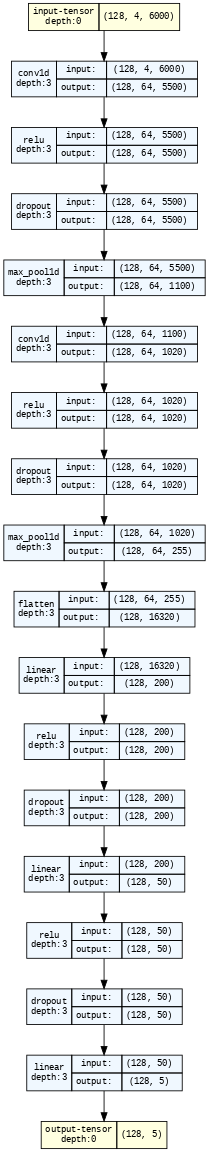

In [27]:
# @title Network Visualisation
#creates a graph visualization of the network
model_graph_1 = torchview.draw_graph(
    model, input_size=(128, 4, 6000),
    graph_name='2Conv',
    hide_inner_tensors=True,
    hide_module_functions=False,
    save_graph = True,
    show_shapes = True,
)
display(Image(filename='/content/2Conv.gv.png'))

Considering large memory demands, it was necessary to train the model remotely. Wandb turned out to be a great tool to evaluate and visualize often marginal changes in the training process. Figure depicting the value of loss (CrossEntropyLoss) on training and validation datasets throughout the learning process is displayed below. Early stopping was employed to find optimal number of epochs with the patience parameter set to 20. After finalizing training weights from the best epoch (128) were loaded.

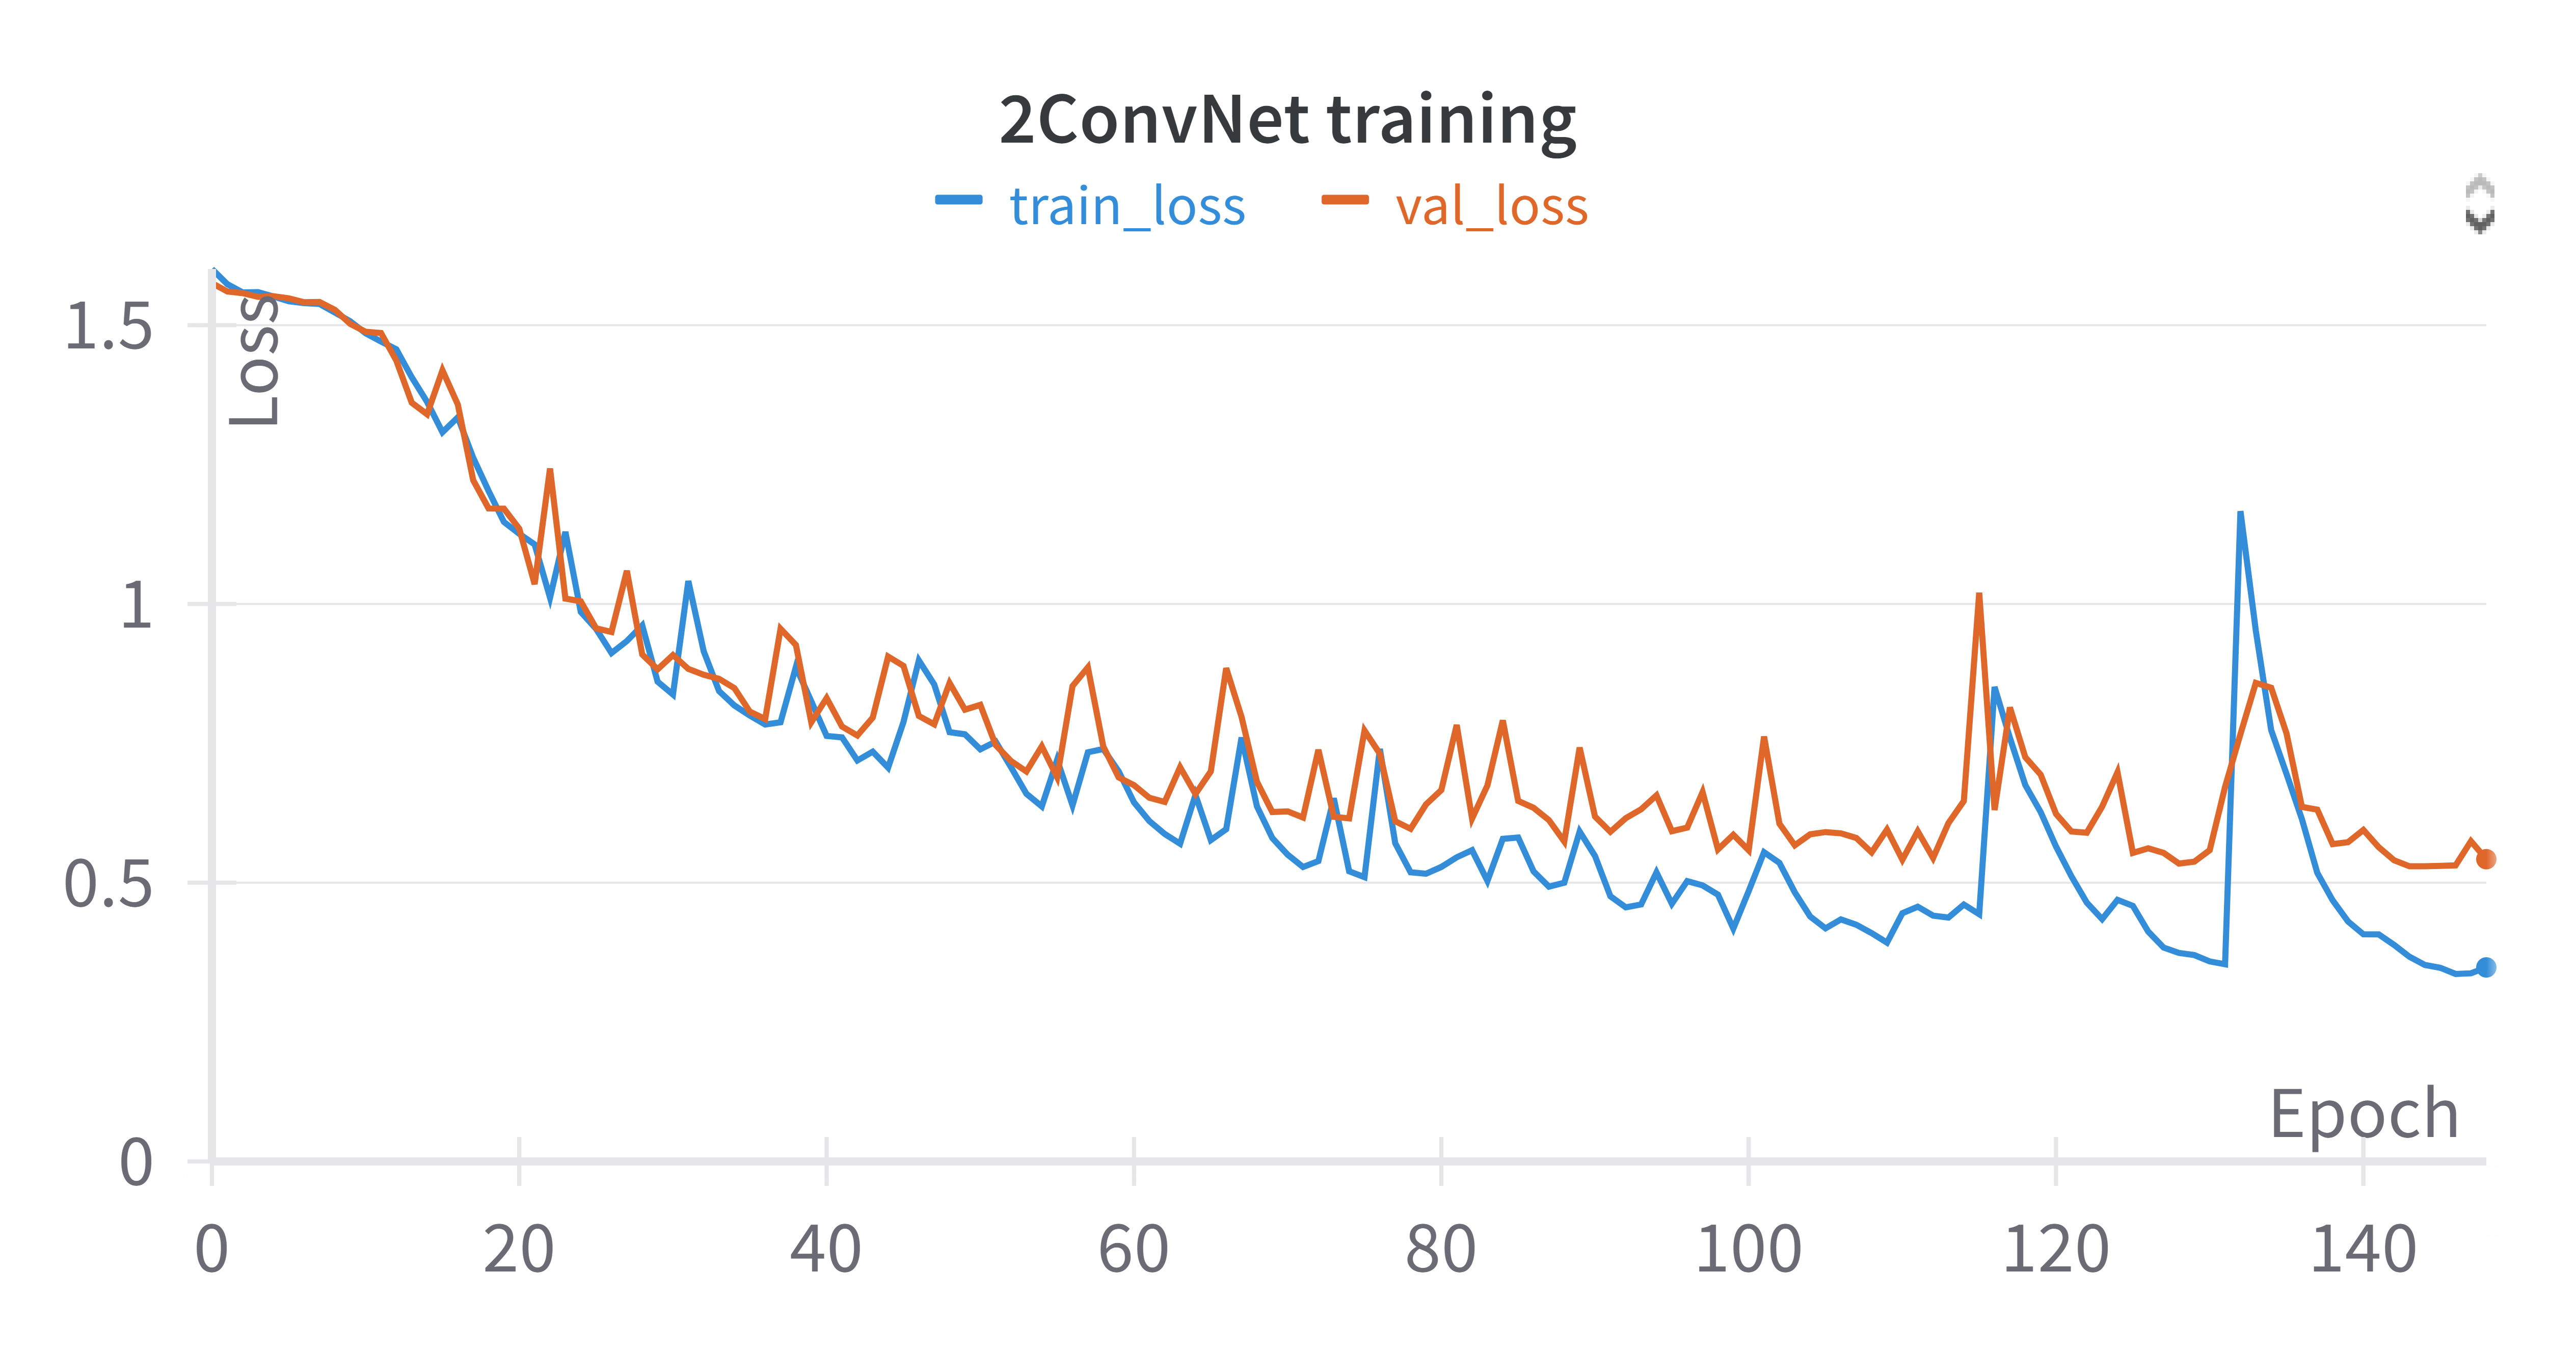

In [28]:
# Shows trining figure
display(Image(filename='/content/23206-final-acoustic-emission-classification/2ConvNet_training.png'))

The following code initializes the lightning trainer and evaluates model performance on Test_dataset. It reaches accuraccy of almost 79%. Our dataset was balanced, so accuracy itself is sufficient to give us a good idea about models performance.

In [7]:
ngpus = torch.cuda.device_count() if torch.cuda.is_available() else 1

trainer = pl.Trainer(devices=ngpus, accelerator="gpu" if torch.cuda.is_available() else "cpu", max_epochs = 100, log_every_n_steps = 10)

trainer.test(model, test_DataLoader)

INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7888000011444092     │
│         test_loss         │    0.5171667337417603     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5171667337417603, 'test_accuracy': 0.7888000011444092}]

## 2. ResConvNet

---

The second implemented network was inspired by ResNet architecture. It uses a helper module *BasicBlock1D* which consists of four consecutive convolutional layers with a residual connection around all of them. The network runs the data through four of these blocks with max pooling layers in between of them. As the length of the data decreases due to pooling, the number of channels increases to prevent too much information loss. Rather extensive visualisation of the network follows its definition.

In [24]:
# @title Definition of pl.LightningModule for ResConvNet

class BasicBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kern_size, drop = 0, stride=1):
        super(BasicBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=kern_size, stride=stride, padding='same', bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=kern_size, stride=1, padding='same', bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size=kern_size, stride=1, padding='same', bias=False)
        self.bn3 = nn.BatchNorm1d(out_channels)
        self.conv4 = nn.Conv1d(out_channels, out_channels, kernel_size=kern_size, stride=1, padding='same', bias=False)
        self.bn4 = nn.BatchNorm1d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        self.dropout = nn.Dropout(drop)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.conv4(out)
        out = self.bn4(out)

        identity = self.downsample(identity)

        out += identity
        out = self.relu(out)

        return out

class ResCNNClassifier(pl.LightningModule):
    def __init__(self, input_channels, num_class, drop):
        super(ResCNNClassifier, self).__init__()

        self.loss = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=num_class)
        self.test_pred = []  # collect predictions
        self.confusion_matrix = MulticlassConfusionMatrix(num_classes=num_class)
        self.drop = drop
        self.check_path = 'Early_Stopping_checkpoint.pth'
        self.min_val_loss = np.inf
        self.best_epoch = 0

        self.block1 = BasicBlock1D(in_channels=input_channels, out_channels=16, kern_size=501, drop=drop)
        self.block2 = BasicBlock1D(in_channels=16, out_channels=32, kern_size=151, drop=drop)
        self.block3 = BasicBlock1D(in_channels=32, out_channels=64, kern_size=71, drop=drop)
        self.block4 = BasicBlock1D(in_channels=64, out_channels=64, kern_size=31, drop=drop)

        self.maxPool1 = nn.MaxPool1d(kernel_size = 4)
        self.maxPool2 = nn.MaxPool1d(kernel_size = 3)
        self.maxPool3 = nn.MaxPool1d(kernel_size = 2)

        self.fc = nn.Sequential(
            nn.Linear(64*250, 200),
            nn.ReLU(),
            nn.Dropout(self.drop),
            nn.Linear(200, 50),
            nn.ReLU(),
            nn.Dropout(self.drop),
            nn.Linear(50, num_class))


    def forward(self, x):
        x = self.block1(x)
        x = self.maxPool1(x)

        x = self.block2(x)
        x = self.maxPool2(x)

        x = self.block3(x)
        x = self.maxPool3(x)

        x = self.block4(x)

        x = x.view(x.size(0), -1)

        return self.fc(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)

        loss = self.loss(outputs, labels)
        self.log('train_loss', loss, sync_dist=True, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        y_target = argmax(labels, dim=1)
        y_pred = argmax(outputs, dim=1)

        acc = self.accuracy(y_pred, y_target)
        self.log('train_accuracy', acc, sync_dist=True, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)

        loss = self.loss(outputs, labels)
        self.log('val_loss', loss, sync_dist=True, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        y_target = argmax(labels, dim=1)
        y_pred = argmax(outputs, dim=1)
        acc = self.accuracy(y_pred, y_target)
        self.log('val_accuracy', acc, sync_dist=True, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)

        loss = self.loss(outputs, labels)
        self.log('test_loss', loss, sync_dist=True, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        y_target = argmax(labels, dim=1)
        y_pred = argmax(outputs, dim=1)
        acc = self.accuracy(y_pred, y_target)
        self.log('test_accuracy', acc, sync_dist=True, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        # Collect predictions
        self.test_pred.extend(y_pred.cpu().numpy())
        # Update confusion matrix
        self.confusion_matrix.update(y_pred, y_target)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def on_validation_epoch_end(self):
        validation_loss = self.trainer.callback_metrics['val_loss']
        if validation_loss < self.min_val_loss:
            self.min_val_loss = validation_loss
            torch.save(self.state_dict(), self.check_path)
            self.best_epoch = self.current_epoch

    def on_train_end(self):
      print(f'Best epoch was epoch {self.best_epoch}. Loading its state.')
      self.load_state_dict(torch.load(self.check_path))

In [18]:
#Model initialisation
Res_model = ResCNNClassifier(input_channels = 4, num_class = 5, drop = 0.1)
#Loading weights
Res_model.load_state_dict(torch.load('/content/23206-final-acoustic-emission-classification/VRTY_residual_CNN_vital_cosmos'))
#print(Res_model)

<All keys matched successfully>

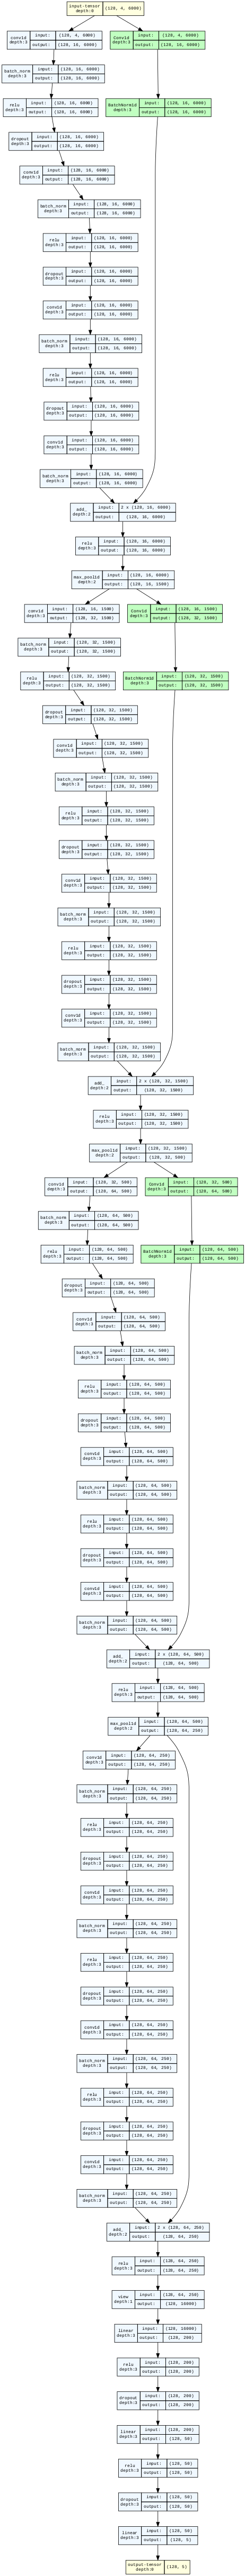

In [29]:
# @title Network visualisation
model_graph_1 = torchview.draw_graph(
    Res_model, input_size=(128, 4, 6000),
    graph_name='ResConvNet',
    hide_inner_tensors=True,
    hide_module_functions=False,
    save_graph = True,
    show_shapes = True,
)
display(Image(filename='/content/ResConvNet.gv.png'))

Training and optimalising the ResConvNet was much more difficult compared to the previous architecture as many more hyperparameters and settings were necessary to tweak and validation loss was very unstable. The networks tends to overfit much more than the previous one, however when using the early stopping with patience of 80 epochs we were able to reach training/validation accuracies of 86.6%/80.9% at epoch 77, which seems like a good compromise. This is backed by the fact that the network classifies the Test dataset with accuracy of 82.6% as seen below.

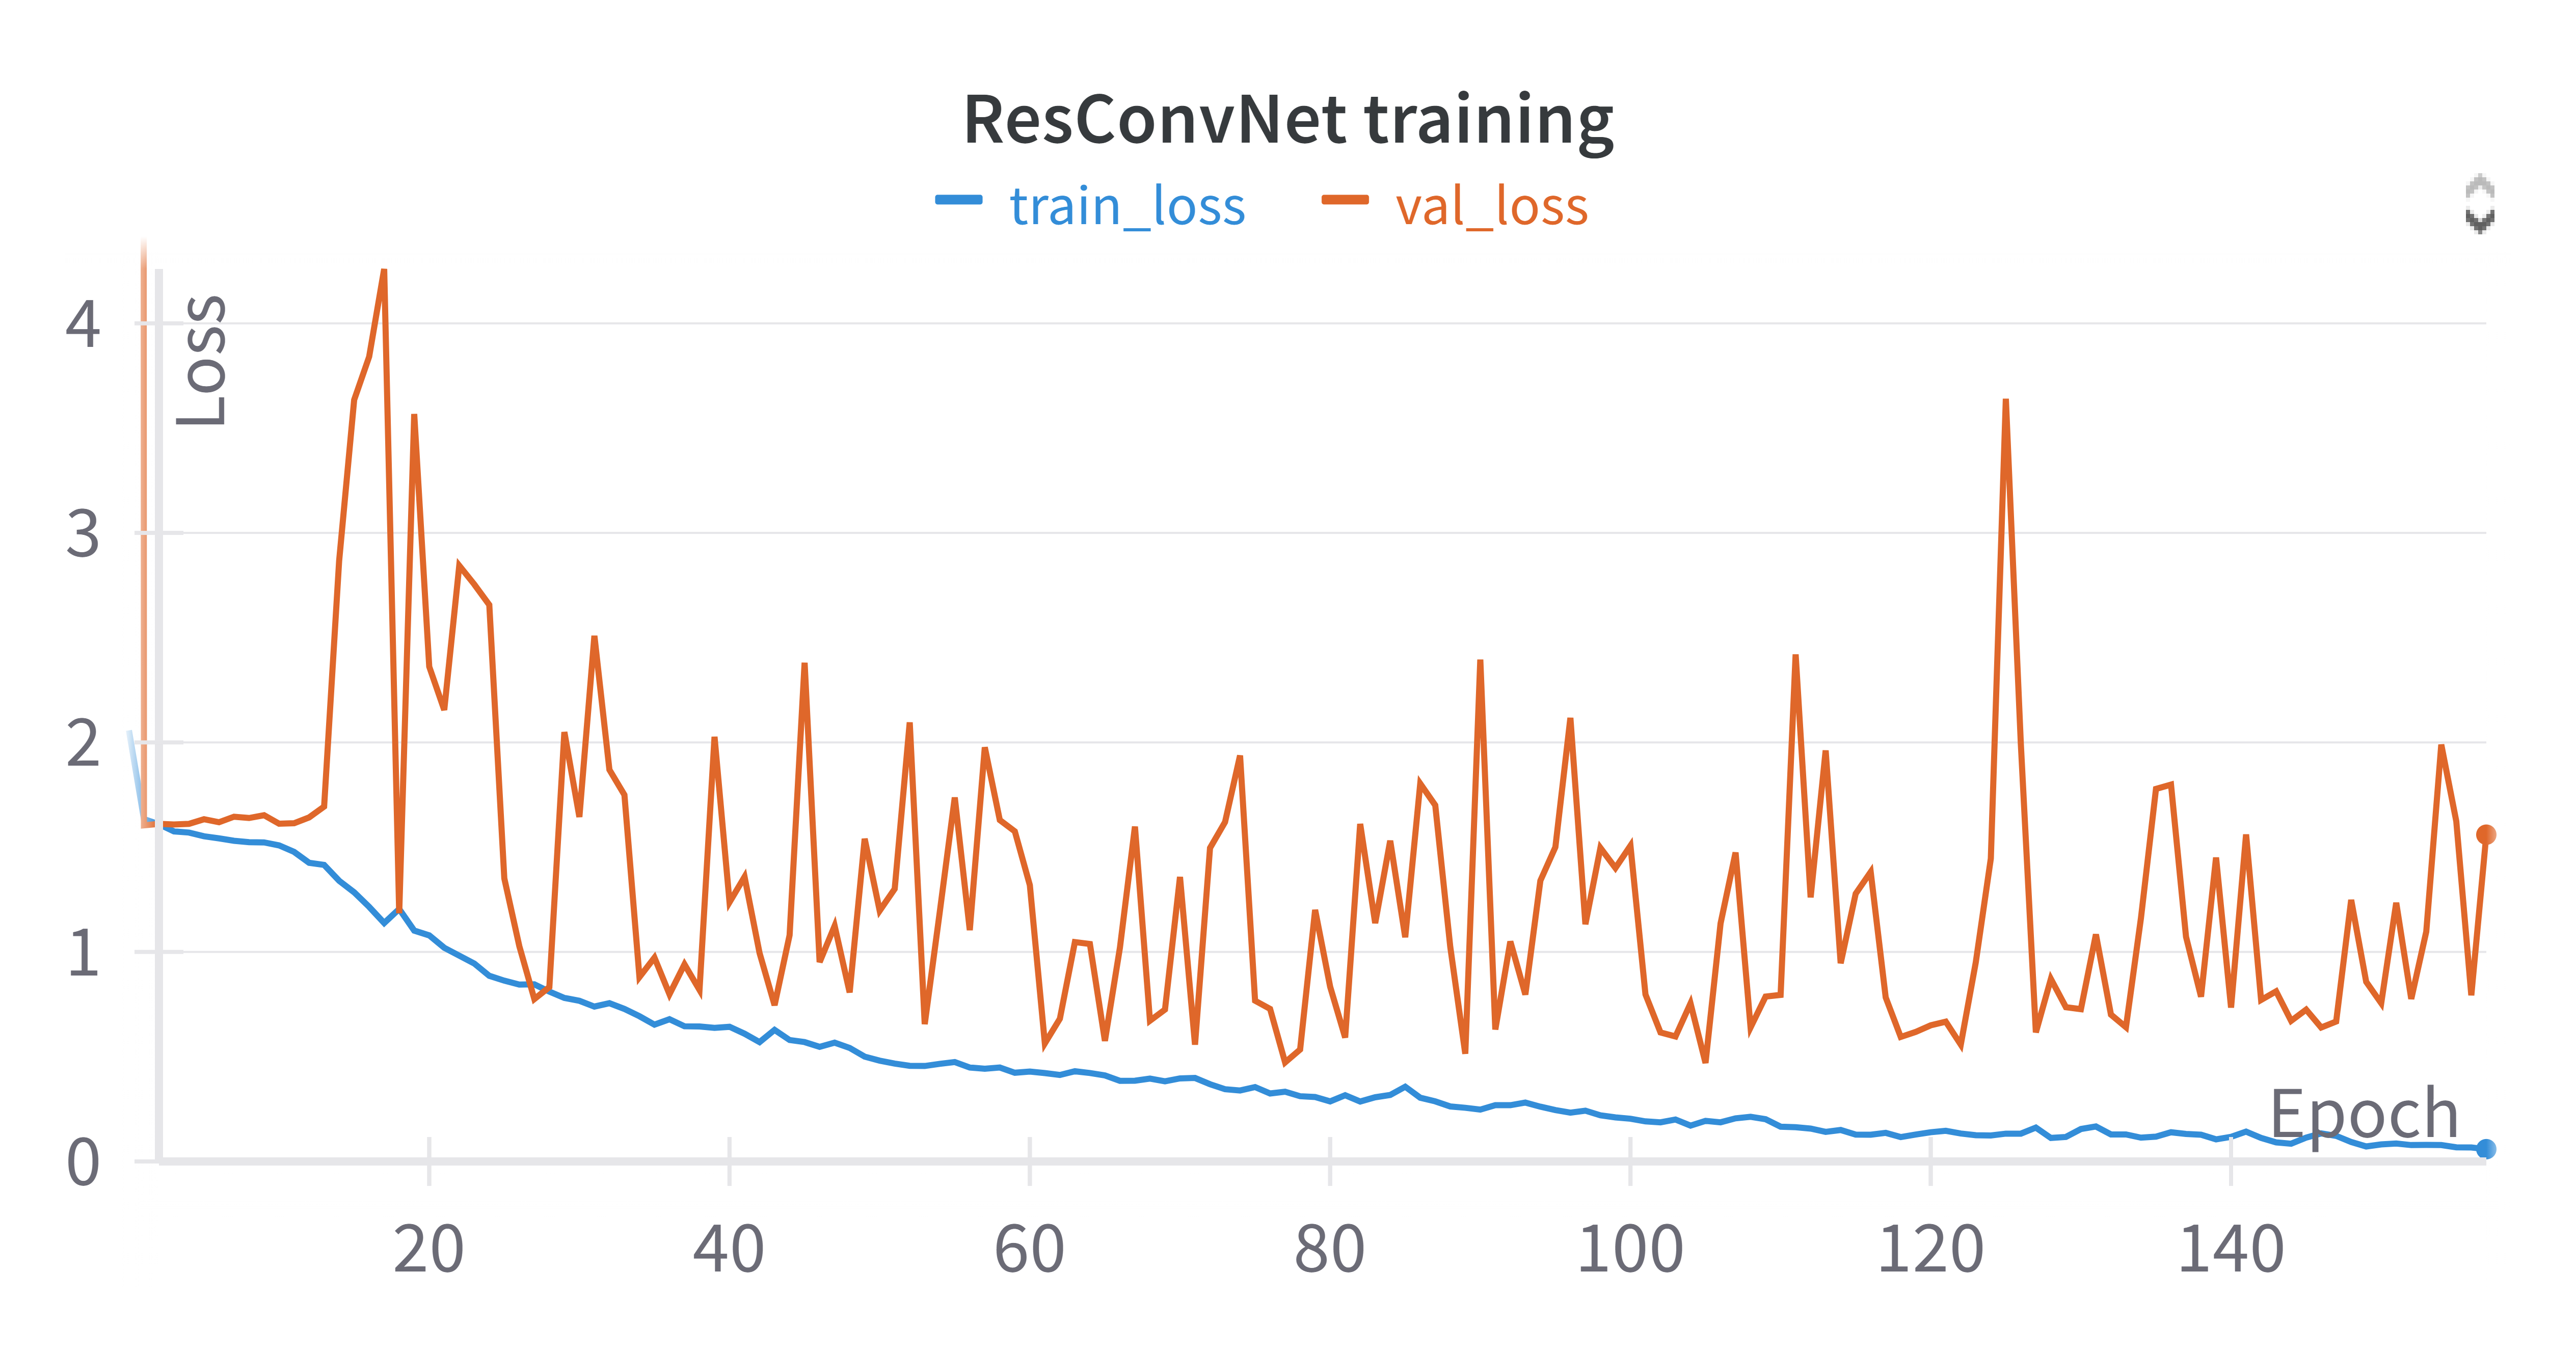

In [3]:
# Shows
img_path = '/content/23206-final-acoustic-emission-classification/ResConvNet_training.png'
display(Image(filename=img_path))

In [23]:
# Evaluation of the test dataset
ngpus = torch.cuda.device_count() if torch.cuda.is_available() else 1

trainer = pl.Trainer(devices=ngpus, accelerator="gpu" if torch.cuda.is_available() else "cpu", max_epochs = 100, log_every_n_steps = 10)

trainer.test(Res_model, test_DataLoader)

INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8256000280380249     │
│         test_loss         │    0.4793235957622528     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4793235957622528, 'test_accuracy': 0.8256000280380249}]

## Conclusion

Luckily, thanks to [1], we can compare our results with a more traditional approach to classification



## References

[1] J. Zavadil: *Selekce příznaků a klasifikace signálů
akustické emise*. Výzkumný úkol, KM FJFI ČVUT, Praha, 2023.